# Prédiction de l'âge d'un opossum à l'aide de la régression

Un groupe de zoologistes vous fournit une dataset regroupant les caractéristiques d'opossums qu'ils ont étudiés et vous demande un programme capable de prédire l'âge d'un opossum à partir de ses caractéristiques.

# 1) Mise en place de l'environnementde travail
## a) Import des librairies necessaires

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## b) Chargement du dataset

In [400]:
df = pd.read_csv('possum.csv')
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# 2) Nettoyage

In [401]:
df.isnull().sum()

case        0
site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64

On a des valeurs nulls qu'on va remplacer par la médiane

In [402]:
imp_mean = SimpleImputer(missing_values=pd.NA, strategy='median')
df[['age', 'footlgth']] = imp_mean.fit_transform(df[['age', 'footlgth']])

On décide aussi de drop la colonne `case` qui n'apporte aucune information utile

In [403]:
df.drop(['case'], axis=1, inplace=True)
df.head()

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# 3) Analyse Exploratoire des Données (AED)
## a) Visualisation numérique

In [422]:
df['age'].describe()

count    104.000000
mean       3.817308
std        1.894112
min        1.000000
25%        2.750000
50%        3.000000
75%        5.000000
max        9.000000
Name: age, dtype: float64

L'âge est compris entre 1 et 9 ans et l'âge moyen est de 3.8 ans

In [405]:
df['sex'].value_counts().to_frame()

,sex
m,61
f,43


Relativement bonne répartition des genres

In [406]:
df['age'].value_counts().to_frame()

,age
3.0,29
2.0,16
4.0,14
5.0,13
6.0,12
1.0,10
7.0,7
9.0,2
8.0,1


L'âge quand a lui est moins bien reparti

In [407]:
df.head()

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


On visualise qu'on a des valeurs non numériques qu'on va encoder : `Pop` et `sex`

In [408]:
le = LabelEncoder()
df['Pop'] = le.fit_transform(df.Pop) #Pop = 0 --> Vic      Pop = 1 --> other
df['sex'] = le.fit_transform(df.sex) #sex = 0 --> male     sex = 1 --> female
df.head()

,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,0,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,0,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,0,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,0,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,0,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


## b) Correlation

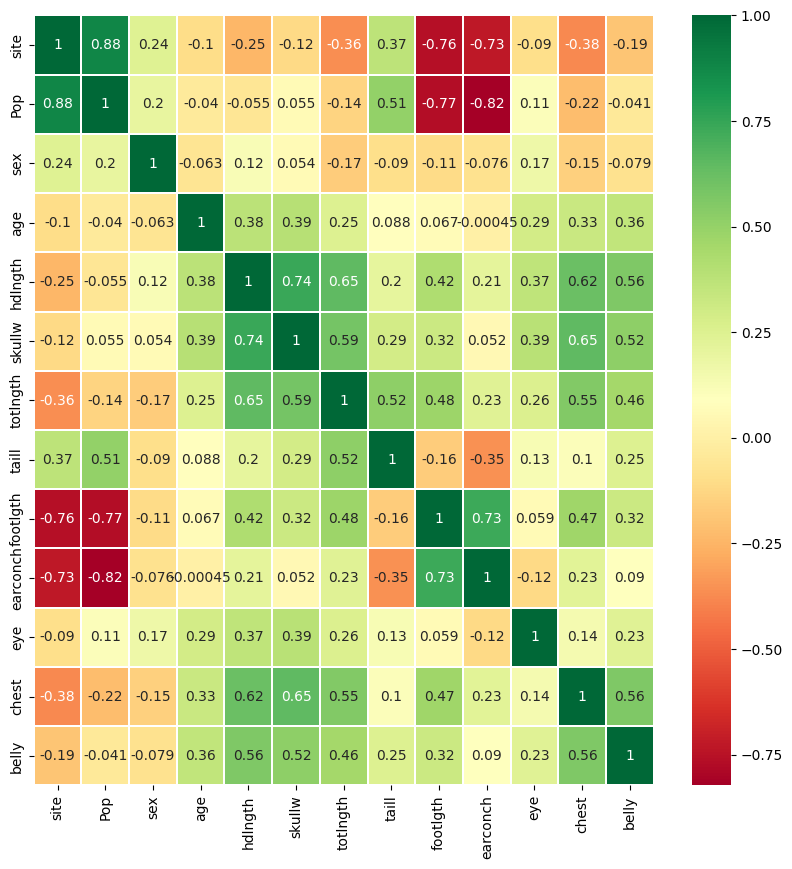

In [409]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10})
plt.show()

On drop `earconch`, `footlgth`, `taill`, `sex`, `pop`, `site` qui n'ont quasiment aucune correlation avec la sortie `age`

In [410]:
df.drop(['earconch'], axis=1, inplace=True)
df.drop(['footlgth'], axis=1, inplace=True)
df.drop(['taill'], axis=1, inplace=True)
df.drop(['sex'], axis=1, inplace=True)
df.drop(['Pop'], axis=1, inplace=True)
df.drop(['site'], axis=1, inplace=True)
df.head() 

,age,hdlngth,skullw,totlngth,eye,chest,belly
0,8.0,94.1,60.4,89.0,15.2,28.0,36.0
1,6.0,92.5,57.6,91.5,16.0,28.5,33.0
2,6.0,94.0,60.0,95.5,15.5,30.0,34.0
3,6.0,93.2,57.1,92.0,15.2,28.0,34.0
4,2.0,91.5,56.3,85.5,15.1,28.5,33.0


# 6) Splitter le dataset

In [411]:
y = df['age']
X = df.drop('age', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7) Mise à l'échelle

In [412]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# 8) Choix du modèle

### **Regression linéaire**

In [413]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_scale, y_train)

LinearRegression()

*Score du modèle :*

In [414]:
lin_reg_y_pred = lin_reg_model.predict(X_test_scale)
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_y_pred))
lin_reg_r2 = r2_score(y_test,lin_reg_y_pred)
print("RMSE sur jeu de test",lin_reg_rmse)
print("R² sur jeu de test",lin_reg_r2)

RMSE sur jeu de test 1.895741828977767
R² sur jeu de test 0.2122852121163208


### **KNN Regressor**
*Choix des meilleurs hyper-paramètres* :

In [415]:
param_grid = {'n_neighbors' : np.arange(1,50)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=4)
grid.fit(X_train_scale, y_train)
KNN_regressor = grid.best_estimator_

In [416]:
KNN_regressor.fit(X_train_scale, y_train)

KNeighborsRegressor(n_neighbors=11)

*Score du modèle :*

In [417]:
KNN_y_pred = KNN_regressor.predict(X_test_scale)
KNN_rmse = np.sqrt(mean_squared_error(y_test, KNN_y_pred))
KNN_r2 = r2_score(y_test,KNN_y_pred)
print("RMSE sur jeu de test",KNN_rmse)
print("R² sur jeu de test",KNN_r2)

RMSE sur jeu de test 1.7819992840202605
R² sur jeu de test 0.3039736785896193


### **Regression polynomiale**
*Création des features polynomiales :*

In [418]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)

*Split et mise à l'échelle du nouveau jeu de données :*

In [419]:
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

*Création du modèle polynomial :*

In [420]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train_scale, y_train)

LinearRegression()

*Score du modèle :*

In [421]:
poly_reg_y_pred = poly_reg_model.predict(X_test_scale)
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_pred))
poly_reg_r2 = r2_score(y_test,poly_reg_y_pred)
print("RMSE sur jeu de test",poly_reg_rmse)
print("R² sur jeu de test",poly_reg_r2)

RMSE sur jeu de test 2.3433509593570476
R² sur jeu de test -0.2036086132978836


R² est négatif, cela signifie que le modèle performe moins bien qu'une ligne horizontale

**Au final :** Le modèle le plus performant est *KNN Regressor*

# 9) Sauvegarde du modèle et du scaler

In [346]:
joblib.dump(KNN_regressor, 'final_model')
joblib.dump(scaler, 'scaler')

['scaler']